Circular Restricted 3 Body Problem (CR3BP)

In [1]:
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt

Definition of the functions used later in the code like the equations of motion or the single-shooting differenciation correction

In [2]:
def halo_propagator_with_STM(state,t):
    x = state[0]
    y = state[1]
    z = state[2]
    vx = state[3]
    vy = state[4]
    vz = state[5]
    mu = state[42]
    r1 = np.sqrt((x+mu)**2 + y**2 + z**2)
    r2 = np.sqrt((x-1+mu)**2 + y**2 + z**2)
    
    statedot = np.zeros((43,1))
    statedot[0] = vx
    statedot[1] = vy
    statedot[2] = vz
    statedot[3] = x + 2*vy - (1-mu)*(x+mu)/(r1**3) - mu*(x-1+mu)/(r2**3)
    statedot[4] = y - 2*vx -(1-mu)*y/(r1**3) - mu*y/(r2**3)
    statedot[5] = -(1-mu)*z/(r1**3) - mu*z/(r2**3)
    
    dUdxx = 1 - (1-mu)/(r1**3) + 3*(1-mu)*(x+mu)**2/(r1**5) - mu/(r2**3) + 3*mu*(x-1+mu)**2/(r2**5)
    dUdyy = 1 - (1-mu)/(r1**3) + 3*(1-mu)*(y**2)/(r1**5) - mu/(r2**3) + 3*mu*(y**2)/(r2**5)
    dUdzz = -(1-mu)/(r1**3) + 3*(1-mu)*(z**2)/(r1**5) - mu/(r2**3) + 3*mu*(z**2)/(r2**5)
    dUdxy = 3*(1-mu)*(x+mu)*y/(r1**5) + 3*mu*(x-1+mu)*y/(r2**5)
    dUdxz = 3*(1-mu)*(x+mu)*z/(r1**5) + 3*mu*(x-1+mu)*z/(r2**5)
    dUdyz = 3*(1-mu)*y*z/(r1**5) + 3*mu*y*z/(r2**5)
    
    A = np.matrix([[0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 1],
         [dUdxx, dUdxy, dUdxz, 0, 2, 0],
         [dUdxy, dUdyy, dUdyz, -2, 0, 0],
         [dUdxz, dUdyz, dUdzz, 0, 0, 0]])

    STM = np.matrix([[state[6], state[7], state[8], state[9], state[10], state[11]],
           [state[12], state[13], state[14], state[15], state[16], state[17]],
           [state[18], state[19], state[20], state[21], state[22], state[23]],
           [state[24], state[25], state[26], state[27], state[28], state[29]],
           [state[30], state[31], state[32], state[33], state[34], state[35]],
           [state[36], state[37], state[38], state[39], state[40], state[41]]])
    
    dSTMdt = A@STM
    # print(statedot[6:12].shape,dSTMdt[0,:].shape,dSTMdt[0,:].T.shape)
    statedot[6:12] = dSTMdt.T[:,0]
    statedot[12:18] = dSTMdt.T[:,1]
    statedot[18:24] = dSTMdt.T[:,2]
    statedot[24:30] = dSTMdt.T[:,3]
    statedot[30:36] = dSTMdt.T[:,4]
    statedot[36:42] = dSTMdt.T[:,5]
    # print(statedot,statedot.reshape(len(statedot)))
    return statedot.reshape(len(statedot))

def halo_propagator(state,t):
    x = state[0]
    y = state[1]
    z = state[2]
    vx = state[3]
    vy = state[4]
    mu = state[6]
    r1 = np.sqrt((x+mu)**2 + y**2 + z**2)
    r2 = np.sqrt((x-1+mu)**2 + y**2 + z**2)
    
    statedot = np.zeros(7)
    statedot[0] = vx
    statedot[1] = vy
    statedot[2] = state[5]
    statedot[3] = x + 2*vy - (1-mu)*(x+mu)/(r1**3) - mu*(x-1+mu)/(r2**3)
    statedot[4] = y - 2*vx -(1-mu)*y/(r1**3) - mu*y/(r2**3)
    statedot[5] = -(1-mu)*z/(r1**3) - mu*z/(r2**3)
    return statedot

def single_shooting(initial_state,residual,jacobian):
    new_initial_state = initial_state.reshape((3,1)) - np.linalg.pinv(jacobian)@(residual.reshape((3,1)))
    return new_initial_state

def optimization(initial_conditions,period,max_iter=1000,tol=1e-5,step=3000):
    adjusted_conditions = initial_conditions
    tf = period/2
    t_simulation = np.linspace(0,tf,step)
    
    for i in range(max_iter):
        # integrate to get the position at the end of one orbit
        print(adjusted_conditions,t_simulation)
        y_temp = integrate.odeint(halo_propagator_with_STM,adjusted_conditions,t_simulation,rtol=1e-12, atol=1e-12)
        f = np.matrix([y_temp[-1,1], y_temp[-1,3], y_temp[-1,5]])
        print(np.linalg.norm(f))
        
        if np.linalg.norm(f)<tol:
            adjusted_conditions[0] = y_temp[0,0]
            adjusted_conditions[4] = y_temp[0,4]
            break
        else:
            # use the ode function to compute the derivatives easily
            state_end = halo_propagator(y_temp[-1,:],t_simulation[-1])
            
            df = np.matrix([[y_temp[-1,12], y_temp[-1,16], state_end[1]],
                  [y_temp[-1,24], y_temp[-1,28], state_end[3]],
                  [y_temp[-1,36], y_temp[-1,40], state_end[5]]])
            
            new_x = single_shooting(np.matrix([adjusted_conditions[0],adjusted_conditions[4],tf]),f,df) # changer les arguments
            # print(new_x[1,0])
            adjusted_conditions[0] = new_x[0,0]
            adjusted_conditions[4] = new_x[1,0]
            tf = new_x[2,0]
    
    return adjusted_conditions,tf

Data is given for the Earth-Moon system

In [3]:
r12 = 389703 # km, distance between primary attractors
mu = 1.215058560962404e-2 # no unit, mass parameter of the system
TU = 382981 # s, inverse of the relative angular frequency between the two primary attractors
L2x = 1.15568217 # position of the L2 point

Getting the initial state guesses with https://ssd.jpl.nasa.gov/tools/periodic_orbits.html to plot the whole L2 Northern Halo orbits family

In [4]:
x0 = [1.1808985497899205E+0, 1.1807299126562403E+0, 1.1802432007231030E+0, 1.1794814105552625E+0, 1.1784496916179399E+0,
      1.1772049627468157E+0, 1.1757357974855753E+0, 1.1740583104016364E+0, 1.1721212352395958E+0, 1.1699952083306175E+0,
      1.1677006591947434E+0, 1.1652591082218164E+0, 1.1626929203920950E+0, 1.1599142517039056E+0, 1.1571604941196401E+0,
      1.1542263493262155E+0, 1.1513800635090152E+0, 1.1485259549360594E+0, 1.1455413442894928E+0, 1.1427323976670050E+0, 
      1.1398248385779477E+0, 1.1369842439274436E+0, 1.1340654944747190E+0, 1.1310749646265861E+0, 1.1281911619625644E+0, 
      1.1252564593293650E+0, 1.1222780089124029E+0, 1.1192632353862111E+0, 1.1162196069793926E+0, 1.1131543850560104E+0,
      1.1098928777210029E+0, 1.1068039033622386E+0, 1.1035300322591290E+0, 1.1002579217768833E+0, 1.0969915644292789E+0, 
      1.0935531551495765E+0, 1.0901265457836595E+0, 1.0867128634138150E+0, 1.0831337559276397E+0] # nd

y0 = [-2.5444988241150091E-26, -3.9224900862468671E-27, -4.0131763697449768E-27, -3.3912217928592086E-27, -5.4426459074481046E-27,
      3.4536760079285946E-27, -2.4315077582384360E-28, 1.4616208552339063E-28, 4.3976196849120970E-29, -2.0139114798129488E-28, 
      4.0672599863558720E-28, 8.3768387931258446E-28, -1.6721129610932788E-28, -2.3173380562008736E-28, -6.0743358593137044E-28,
      -6.2944595408249574E-28, 7.1390708216286326E-29, 3.1565990810495496E-28, 1.6192114933067259E-27, -9.4723070232695753E-28, 
      2.3639470684970793E-27, 2.4486207109097478E-27, -2.1292148592828467E-27, -9.8852194218501502E-28, 7.6541498074543159E-27,
      3.4582554314059270E-27, 4.9312297519955555E-28, 5.9854005070830337E-28, 1.0397089411165433E-27, 2.5445211165619221E-27,
      -3.2370214994299834E-27, -3.7763309589608048E-27, 1.4131620744948173E-27, 1.6426007027565626E-27, -1.3906893609387349E-27, 
      -3.0099620762482007E-27, -3.3929555608982004E-28, 8.0304267092243950E-30, 1.1706458956133718E-26] # nd

z0 = [1.0295054075242347E-4, 1.3121069431778331E-2, 2.5617923919654416E-2, 3.7178973271809496E-2, 4.8140435768697247E-2, 
      5.8225138268011067E-2, 6.7801780194122280E-2, 7.6909584828747435E-2, 8.5877005926413993E-2, 9.4422999379980818E-2, 
      1.0256492290418533E-1, 1.1031384321787237E-1, 1.1767600543672109E-1, 1.2493104137908298E-1, 1.3152090959188770E-1,
      1.3799262593245051E-1, 1.4380485557811437E-1, 1.4922846889506389E-1, 1.5451145148373718E-1, 1.5915200933380999E-1, 
      1.6364154884722404E-1, 1.6773758461592672E-1, 1.7166247666605308E-1, 1.7539783791199678E-1, 1.7873519017004103E-1, 
      1.8187257007554328E-1, 1.8479677771071973E-1, 1.8749672012259902E-1, 1.8996401464715618E-1, 1.9219343403238076E-1,
      1.9429272244184692E-1, 1.9603030754249040E-1, 1.9761601341425358E-1, 1.9894909370174629E-1, 2.0004092398988046E-1, 
      2.0094617631480924E-1, 2.0161377613193826E-1, 2.0206059408320026E-1, 2.0231055618100155E-1] # nd

vx0 = [3.3765359485568778E-15, 2.5207120235612143E-15, 2.6505334124465135E-15, 3.5657215709679162E-15, -2.5260992021190302E-15,
       9.2876289344915468E-16, -2.1060536016712307E-15, -2.7746128158444920E-15, -2.8399759059065597E-15, -4.9656594086928137E-16,
       -1.0417705214131128E-15, -2.1459660712392417E-15, 6.6655743243173158E-16, 1.2307479474947080E-15, 1.4776297513298329E-15,
       4.1794997459487238E-15, 3.0283461616922221E-15, 4.2917354658873129E-15, 3.4242613219894274E-15, 5.9154586036713890E-15,
       5.3692753492503482E-15, 4.1935762479173162E-15, 3.9613389302666476E-15, 3.4952440956136861E-15, -1.2630506284953841E-15, 
       -5.5891287188789060E-16, -3.1687920458283919E-16, 5.2868361571034389E-16, -2.3824535810123310E-15, -9.2916156853283232E-16,
       4.8664558894610642E-16, 1.1792722431053536E-15, 8.1496282395178728E-16, 7.4879463226110969E-16, 4.9047891808896165E-15, 
       3.4271448531393373E-15, 1.1386658764907653E-14, 1.1192016952016542E-14, 8.3292712433950044E-15] # nd

vy0 = [-1.5585631393981156E-1, -1.5684752073236072E-1, -1.5954905069606692E-1, -1.6338139359639692E-1, -1.6797405042301869E-1, 
       -1.7282597331742994E-1, -1.7782655254524235E-1, -1.8280860876068225E-1, -1.8782217382326816E-1, -1.9261435418133890E-1, 
       -1.9712508121327701E-1, -2.0131471324908751E-1, -2.0515853269673287E-1, -2.0877759243379301E-1, -2.1188791433341295E-1,
       -2.1474891071483865E-1, -2.1712922972872784E-1, -2.1916532303628991E-1, -2.2095226684799862E-1, -2.2233902828510901E-1, 
       -2.2349331292348754E-1, -2.2436040946170996E-1, -2.2499619681915137E-1, -2.2539063500356940E-1, -2.2553347911252272E-1, 
       -2.2544675199362010E-1, -2.2512563128868165E-1, -2.2456703699414379E-1, -2.2376980465129670E-1, -2.2273474373483881E-1,
       -2.2138261166524692E-1, -2.1986831677048768E-1, -2.1802034988367752E-1, -2.1592883120638881E-1, -2.1360265558047956E-1, 
       -2.1090275486068658E-1, -2.0796204285184380E-1, -2.0479030592633110E-1, -2.0121168055184560E-1] # nd

vz0 = [5.5263881873244218E-18, 1.1007889483810504E-15, 5.4577430591805649E-15, 4.4439926659633611E-15, 9.8199001002925144E-15, 
       1.1032674450864492E-14, 1.7594110167841084E-14, 1.4809505158598828E-14, 1.6774526301835190E-16, 3.8537854741228954E-15, 
       2.2798663794896066E-15, -4.7168468693615866E-16, -2.5760642407696903E-15, -4.7596301953914308E-15, -1.2326017791389893E-14,
       -8.0790091421123428E-15, -1.9547204857788442E-15, -2.8427505695990620E-15, -2.2634800484517227E-15, -3.7801420730129741E-15, 
       -4.8011160052121524E-15, -4.5209590114403008E-15, -3.2397902355862227E-15, -4.8486629407260712E-15, -3.4633466525785658E-15, 
       -1.5886999426493357E-15, -3.4416453607522604E-15, -6.7328707463436131E-15, -9.8830793422649480E-15, -9.2655794365851240E-15,
       -4.9325030141434507E-15, 1.3528599320325566E-15, -8.8844976835138455E-16, -4.9874747883170076E-15, 6.6909069485186488E-15, 
       1.0078939073787943E-15, -2.8195151432675860E-14, -3.6204794938766712E-14, -3.8933834984161984E-14] # nd

L1x = 0.83691513 # nd, along the x direction
L2x = 1.15568217 # nd, along the x direction

# initial_position = [x0 y0 z0]';
# initial_velocity = [vx0 vy0 vz0]';
initial_STM = np.asarray([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1])
# initial_conditions = [initial_position; initial_velocity; initial_STM; mu];

period = [3.4155308065628454E+0, 3.4141232367543708E+0, 3.4101539733562030E+0, 3.4041666282888854E+0, 3.3963805494683674E+0, 
          3.3873299978687315E+0, 3.3769669271238048E+0, 3.3653986536399993E+0, 3.3522346943474246E+0, 3.3378824002096996E+0, 
          3.3223749314308342E+0, 3.3057376675493617E+0, 3.2879941141468882E+0, 3.2683796978298347E+0, 3.2484349509162689E+0,
          3.2265351027754612E+0, 3.2045676617775203E+0, 3.1817478106944685E+0, 3.1569602099666483E+0, 3.1327035113287223E+0, 
          3.1065871267784422E+0, 3.0800303869394452E+0, 3.0516246962540947E+0, 3.0213062208215136E+0, 2.9908794086451036E+0, 
          2.9587012252195288E+0, 2.9247896381352474E+0, 2.8891920020877224E+0, 2.8519851641669658E+0, 2.8132733875316878E+0,
          2.7707861925069994E+0, 2.7293971867214561E+0, 2.6844146154370518E+0, 2.6384276046753588E+0, 2.5916248068584653E+0, 
          2.5415355492607352E+0, 2.4909336664289770E+0, 2.4399955442394532E+0, 2.3861839336103214E+0] # in TU

Single-shooting differenciation correction of the initial guesses

[1.1808985497899205, -2.544498824115009e-26, 0.00010295054075242347, 3.3765359485568778e-15, -0.15585631393981156, 5.526388187324422e-18, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0.01215058560962404] [0.00000000e+00 5.69444949e-04 1.13888990e-03 ... 1.70662651e+00
 1.70719596e+00 1.70776540e+00]
3.4389923302487705e-13
[1.1807299126562403, -3.922490086246867e-27, 0.013121069431778331, 2.5207120235612143e-15, -0.15684752073236072, 1.1007889483810504e-15, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0.01215058560962404] [0.00000000e+00 5.69210276e-04 1.13842055e-03 ... 1.70592320e+00
 1.70649241e+00 1.70706162e+00]
3.067081683160332e-13
[1.180243200723103, -4.013176369744977e-27, 0.025617923919654416, 2.6505334124465135e-15, -0.15954905069606692, 5.457743059180565e-15, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 

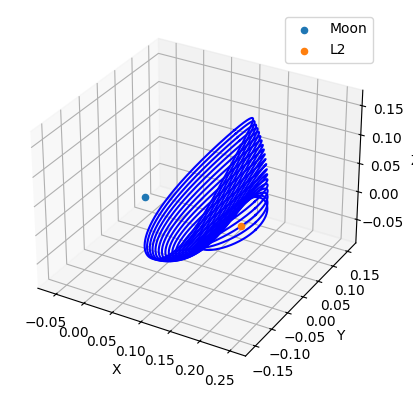

In [5]:
ax = plt.figure().add_subplot(projection='3d')

for i in range(len(period[::2])):
    T = period[i]
    initial_conditions = [x0[i], y0[i], z0[i], vx0[i], vy0[i], vz0[i]]
    for j in initial_STM:
        initial_conditions.append(j)
    initial_conditions.append(mu)
    # print(initial_conditions)
    [adjusted_conditions,tf] = optimization(initial_conditions,T)
    x0[i] = adjusted_conditions[0]
    y0[i] = adjusted_conditions[1]
    z0[i] = adjusted_conditions[2]
    vx0[i] = adjusted_conditions[3]
    vy0[i] = adjusted_conditions[4]
    vz0[i] = adjusted_conditions[5]
    period[i] = 2*tf
    
    t_simulation = np.linspace(0,period[i],3000)
    y_orbit = integrate.odeint(halo_propagator_with_STM,adjusted_conditions,t_simulation)
    ax.plot(y_orbit[:,0]-np.ones_like(y_orbit[:,0])*(1-mu),y_orbit[:,1],y_orbit[:,2],color='b')

ax.scatter(0, 0, 0, label='Moon')
ax.scatter(L2x-(1-mu), 0, 0, label='L2')
ax.axis('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend() 
plt.grid() 
plt.show()
    
    